In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
from skimage import io
from PIL import Image
from sklearn.metrics import confusion_matrix
import pdb
import torch.nn.functional as F
from pytictoc import TicToc

from utils_v2 import *
from models import *

In [2]:
t = TicToc() #create instance of class

In [3]:
train_loader = create_dataloaders(batch_size=64, version='_Goose_1st_TVT')

In [4]:
len(train_loader)

238

In [5]:
t.tic() #Start timer
for batch_idx, (data, label, date, rec, time) in enumerate(train_loader): # check shapes
    print(data.shape)
    print(label.shape)
    print(len(date))
    print(len(rec))
    print(len(time))
    break
t.toc() #Time elapsed since t.tic()

torch.Size([64, 62, 100, 10])
torch.Size([64, 1])
64
64
64
Elapsed time is 1.282298 seconds.


torch.Size([64, 62, 100, 10])
torch.Size([64, 1])
64
64
64

date:180325, rec:001, time:4956.0


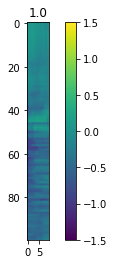

date:180325, rec:007, time:590.0


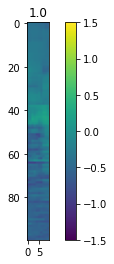

In [6]:
(data, label, date, rec, time) = next(iter(train_loader))
print(data.shape)
print(label.shape)
print(len(date))
print(len(rec))
print(len(time))
print()

for i in range(2):
        print('date:{}, rec:{}, time:{}'.format(date[i], rec[i], time[i]))
        data_sub = data[i][0]
        plt.imshow(data_sub)
        plt.clim(-1.5, 1.5)
        plt.colorbar()
        plt.title(label[i][0].numpy())
        plt.show()

In [5]:
# model = CNN_small()
# print(model)

model = GLM()
print(model)

GLM(
  (linear): Linear(in_features=62000, out_features=1, bias=True)
)


In [6]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
    device = torch.device('cpu')
else:
    print('CUDA is available!')
    device = torch.device('cuda')

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
    print('Moving model on GPU...')
print("Model parameters on cuda:",next(model.parameters()).is_cuda)

CUDA is available!
Moving model on GPU...
Model parameters on cuda: True


In [7]:
learning_rate = 0.001
num_epochs = 2
alpha = 0
model_type = 'GLM'
loss_type = 'bce'
reg_type = 'none'
CH = 'all'

criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [17]:
model.train() # set the network in training mode

epochs = 2
train_losses, test_losses, acc_list = [], [], []

for epoch in range(1,epochs+1):
    running_loss = 0
    for (data, label,_,_,_) in train_loader:
        
        #         labels = labels.long() # change label type from int to long 
        data = data.type(torch.FloatTensor)
        label = label.type(torch.FloatTensor) # convert labels to Float for BCELoss

        
        if train_on_gpu: # move data on GPU
            data, label = data.cuda(), label.cuda()
              
        # Clear the gradients
        optimizer.zero_grad()
        
        outputs = model(data)
        outputs = outputs.reshape(outputs.shape[0],-1)        # logits, conv_x1, conv_x2 = model(images) # forward pass - conv small
        # logits = model(images) # forward pass - LR, MLP
        loss = criterion(torch.sigmoid(outputs), label)        
        loss.backward() # backpropagate to compute the gradients
        optimizer.step() # update the weights
        
        running_loss =+ loss.item()
         
            
            
        train_losses.append(running_loss/len(train_loader))

            
        ############################
        # PRINT ACCURACTY AND LOSSES
        ############################
#         if epoch % 10 == 0:
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.7f}.. ".format(running_loss/len(train_loader)))

Epoch: 2/2..  Training Loss: 1.2418046.. 
Epoch: 2/2..  Training Loss: 1.9219887.. 
Epoch: 2/2..  Training Loss: 1.3510343.. 
Epoch: 2/2..  Training Loss: 3.1131335.. 
Epoch: 2/2..  Training Loss: 1.6133311.. 
Epoch: 2/2..  Training Loss: 2.7011147.. 
Epoch: 2/2..  Training Loss: 0.3099087.. 
Epoch: 2/2..  Training Loss: 0.7835620.. 
Epoch: 2/2..  Training Loss: 0.4133605.. 
Epoch: 2/2..  Training Loss: 0.5644102.. 
Epoch: 2/2..  Training Loss: 1.1484201.. 
Epoch: 2/2..  Training Loss: 0.5762372.. 
Epoch: 2/2..  Training Loss: 0.5768402.. 
Epoch: 2/2..  Training Loss: 0.1168873.. 
Epoch: 2/2..  Training Loss: 0.5310681.. 
Epoch: 2/2..  Training Loss: 1.1354003.. 
Epoch: 2/2..  Training Loss: 0.4458124.. 
Epoch: 2/2..  Training Loss: 0.2256638.. 
Epoch: 2/2..  Training Loss: 0.2726244.. 
Epoch: 2/2..  Training Loss: 0.7255162.. 
Epoch: 2/2..  Training Loss: 0.4067928.. 
Epoch: 2/2..  Training Loss: 0.4337060.. 
Epoch: 2/2..  Training Loss: 0.7866194.. 
Epoch: 2/2..  Training Loss: 0.141

KeyboardInterrupt: 

In [8]:
epochs, training_losses, training_acc, val_losses, validation_acc = [], [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
    print('Train loss for epoch {}: {}'.format(epoch, train_loss))
#     val_loss, val_acc = evaluate(model, optimizer, val_loader, alpha=alpha, model_type=model_type, loss_type=loss_type, reg_type=reg_type, collect_result=False, device=device)
#     print('Val loss for epoch {}: {}'.format(epoch, val_loss))
#     if val_losses:
#         if val_loss < min(val_losses):
#             best_epoch = epoch
#             print(epoch)
#             path = '/mnt/pesaranlab/People/Capstone_students/Yue/model/model_Goose_1st_1_upsample'
#             torch.save(model.state_dict(), '{}/{}_CH{}_LOSS{}_REG{}{}_EPOCH{}.pt'.format(path, model_type, CH, loss_type, reg_type, alpha, epoch))

batch index:  0
Training...
Computing loss...
Updating weights...
batch index:  1
Training...
Computing loss...
Updating weights...
batch index:  2
Training...
Computing loss...
Updating weights...
batch index:  3
Training...
Computing loss...
Updating weights...
batch index:  4
Training...
Computing loss...
Updating weights...
batch index:  5
Training...
Computing loss...
Updating weights...
batch index:  6
Training...
Computing loss...
Updating weights...
batch index:  7
Training...
Computing loss...
Updating weights...
batch index:  8
Training...
Computing loss...
Updating weights...
batch index:  9
Training...
Computing loss...
Updating weights...
batch index:  10
Training...
Computing loss...
Updating weights...
batch index:  11
Training...
Computing loss...
Updating weights...
batch index:  12
Training...
Computing loss...
Updating weights...
batch index:  13
Training...
Computing loss...
Updating weights...
batch index:  14
Training...
Computing loss...
Updating weights...
batch

KeyboardInterrupt: 